# A Problem that Stumped Milton Friedman

(and that Abraham Wald solved by inventing sequential analysis)


<a id='index-1'></a>

## Contents

- [A Problem that Stumped Milton Friedman](#A-Problem-that-Stumped-Milton-Friedman)  
  - [Overview](#Overview)  
  - [Origin of the problem](#Origin-of-the-problem)  
  - [A dynamic programming approach](#A-dynamic-programming-approach)  
  - [Implementation](#Implementation)  
  - [Analysis](#Analysis)  
  - [Comparison with Neyman-Pearson formulation](#Comparison-with-Neyman-Pearson-formulation)  

Co-authors: [Chase Coleman](https://github.com/cc7768)

## Overview

This lecture describes a statistical decision problem encountered  by Milton
Friedman and W. Allen Wallis during World War II when they were analysts at
the U.S. Government’s  Statistical Research Group at Columbia University

This problem led Abraham Wald [[Wal47]](https://lectures.quantecon.org/py/zreferences.html#wald47) to formulate **sequential analysis**,
an approach to statistical decision problems intimately related to dynamic programming

In this lecture, we apply dynamic programming algorithms to Friedman and Wallis and Wald’s problem

Key ideas in play will be:

- Bayes’ Law  
- Dynamic programming  
- Type I and type II statistical errors  
  - a type I error occurs when you reject a null hypothesis that is true  
  - a type II error is when you accept a null hypothesis that is false  
- Abraham Wald’s **sequential probability ratio test**  
- The **power** of a statistical test  
- The **critical region** of a statistical test  
- A **uniformly most powerful test**  


We’ll begin with some imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import quantecon as qe
from numba import njit, prange, vectorize
from interpolation import interp
from math import gamma

## Origin of the problem

On pages 137-139 of his 1998 book *Two Lucky People* with Rose Friedman [[FF98]](https://lectures.quantecon.org/py/zreferences.html#friedman98),
Milton Friedman described a problem presented to him and Allen Wallis
during World War II, when they worked at the US Government’s
Statistical Research Group at Columbia University

Let’s listen to Milton Friedman tell us what happened

> In order to understand the story, it is necessary to have an idea of a
simple statistical problem, and of the standard procedure for dealing
with it. The actual problem out of which sequential analysis grew will
serve. The Navy has two alternative designs (say A and B) for a
projectile. It wants to determine which is superior. To do so it
undertakes a series of paired firings. On each round it assigns the
value 1 or 0 to A accordingly as its performance is superior or inferio
to that of B and conversely 0 or 1 to B. The Navy asks the statistician
how to conduct the test and how to analyze the results.


> The standard statistical answer was to specify a number of firings (say
1,000) and a pair of percentages (e.g., 53% and 47%) and tell the client
that if A receives a 1 in more than 53% of the firings, it can be
regarded as superior; if it receives a 1 in fewer than 47%, B can be
regarded as superior; if the percentage is between 47% and 53%, neither
can be so regarded.


> When Allen Wallis was discussing such a problem with (Navy) Captain
Garret L. Schyler, the captain objected that such a test, to quote from
Allen’s account, may prove wasteful. If a wise and seasoned ordnance
officer like Schyler were on the premises, he would see after the first
few thousand or even few hundred [rounds] that the experiment need not
be completed either because the new method is obviously inferior or
because it is obviously superior beyond what was hoped for
$ \ldots $


Friedman and Wallis struggled with the problem but, after realizing that
they were not able to solve it,  described the problem to  Abraham Wald

That started Wald on the path that led him  to *Sequential Analysis* [[Wal47]](https://lectures.quantecon.org/py/zreferences.html#wald47)

We’ll formulate the problem using dynamic programming

## A dynamic programming approach

The following presentation of the problem closely follows Dmitri
Berskekas’s treatment in **Dynamic Programming and Stochastic Control** [[Ber75]](https://lectures.quantecon.org/py/zreferences.html#bertekas75)

A decision maker observes iid draws of a random variable $ z $

He (or she) wants to know which of two probability distributions $ f_0 $ or $ f_1 $ governs $ z $

After a number of draws, also to be determined, he makes a decision as to
which of the distributions is generating the draws he observes

He starts with prior

$$
\pi_{-1} =
\mathbb P \{ f = f_0 \mid \textrm{ no observations} \} \in (0, 1)
$$

After observing $ k+1 $ observations $ z_k, z_{k-1}, \ldots, z_0 $, he updates this value to

$$
\pi_k = \mathbb P \{ f = f_0 \mid z_k, z_{k-1}, \ldots, z_0 \}
$$

which is calculated recursively by applying Bayes’ law:

$$
\pi_{k+1} = \frac{ \pi_k f_0(z_{k+1})}{ \pi_k f_0(z_{k+1}) + (1-\pi_k) f_1 (z_{k+1}) },
\quad k = -1, 0, 1, \ldots
$$

After observing $ z_k, z_{k-1}, \ldots, z_0 $, the decision maker believes
that $ z_{k+1} $ has probability distribution

$$
f_{{\pi}_k} (v) = \pi_k f_0(v) + (1-\pi_k) f_1 (v)
$$

This is a mixture of distributions $ f_0 $ and $ f_1 $, with the weight
on $ f_0 $ being the posterior probability that $ f = f_0 $ <sup><a href=#f1 id=f1-link>[1]</a></sup>

To help illustrate this kind of distribution, let’s inspect some mixtures of beta distributions

The density of a beta probability distribution with parameters $ a $ and $ b $ is

$$
f(z; a, b) = \frac{\Gamma(a+b) z^{a-1} (1-z)^{b-1}}{\Gamma(a) \Gamma(b)}
\quad \text{where} \quad
\Gamma(t) := \int_{0}^{\infty} x^{t-1} e^{-x} dx
$$

The next figure shows two beta distributions in the top panel

The bottom panel presents mixtures of these distributions, with various mixing probabilities $ \pi_k $

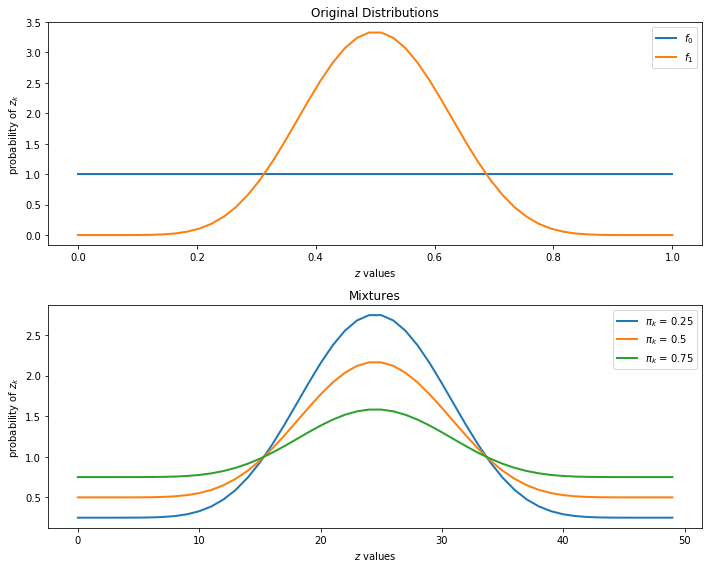

In [2]:
def beta_function_factory(a, b):

    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)

    @njit
    def p_rvs():
        return np.random.beta(a, b)

    return p, p_rvs


f0, _ = beta_function_factory(1, 1)
f1, _ = beta_function_factory(9, 9)
grid = np.linspace(0, 1, 50)

fig, axes = plt.subplots(2, figsize=(10, 8))

axes[0].set_title("Original Distributions")
axes[0].plot(grid, f0(grid), lw=2, label="$f_0$")
axes[0].plot(grid, f1(grid), lw=2, label="$f_1$")

axes[1].set_title("Mixtures")
for π in 0.25, 0.5, 0.75:
    y = π * f0(grid) + (1 - π) * f1(grid)
    axes[1].plot(y, lw=2, label=f"$\pi_k$ = {π}")

for ax in axes:
    ax.legend()
    ax.set(xlabel="$z$ values", ylabel="probability of $z_k$")

plt.tight_layout()
plt.show()

### Losses and costs

After observing $ z_k, z_{k-1}, \ldots, z_0 $, the decision maker
chooses among three distinct actions:

- He decides that $ f = f_0 $ and draws no more $ z $‘s  
- He decides that $ f = f_1 $ and draws no more $ z $‘s  
- He postpones deciding now and instead chooses to draw a
  $ z_{k+1} $  


Associated with these three actions, the decision maker can suffer three
kinds of losses:

- A loss $ L_0 $ if he decides $ f = f_0 $ when actually
  $ f=f_1 $  
- A loss $ L_1 $ if he decides $ f = f_1 $ when actually
  $ f=f_0 $  
- A cost $ c $ if he postpones deciding and chooses instead to draw
  another $ z $  

### Digression on type I and type II errors

If we regard  $ f=f_0 $ as a null hypothesis and $ f=f_1 $ as an alternative hypothesis,
then $ L_1 $ and $ L_0 $ are losses associated with two types of statistical errors

- a type I error is an incorrect rejection of a true null hypothesis (a “false positive”)  
- a type II error is a failure to reject a false null hypothesis (a “false negative”)  


So when we treat $ f=f_0 $ as the null hypothesis

- We can think of $ L_1 $ as the loss associated with a type I
  error  
- We can think of $ L_0 $ as the loss associated with a type II
  error  

### Intuition

Let’s try to guess what an optimal decision rule might look like before we go further

Suppose at some given point in time that $ \pi $ is close to 1

Then our prior beliefs and the evidence so far point strongly to $ f = f_0 $

If, on the other hand, $ \pi $ is close to 0, then $ f = f_1 $ is strongly favored

Finally, if $ \pi $ is in the middle of the interval $ [0, 1] $, then we have little information in either direction

This reasoning suggests a decision rule such as the one shown in the figure

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/wald_dec_rule.png" style="width:60%;height:60%">

  
As we’ll see, this is indeed the correct form of the decision rule

The key problem is to determine the threshold values $ \alpha, \beta $,
which will depend on the parameters listed above

You might like to pause at this point and try to predict the impact of a
parameter such as $ c $ or $ L_0 $ on $ \alpha $ or $ \beta $

### A Bellman equation

Let $ J(\pi) $ be the total loss for a decision maker with current belief $ \pi $ who chooses optimally

With some thought, you will agree that $ J $ should satisfy the Bellman equation


<a id='equation-new1'></a>
$$
J(\pi) =
    \min
    \left\{
        (1-\pi) L_0, \; \pi L_1, \;
        c + \mathbb E [ J (\pi') ]
    \right\} \tag{1}
$$

where $ \pi' $ is the random variable defined by

$$
\pi' = \kappa(z', \pi) = \frac{ \pi f_0(z')}{ \pi f_0(z') + (1-\pi) f_1 (z') }
$$

when $ \pi $ is fixed and $ z' $ is drawn from the current best guess, which is the distribution $ f $ defined by

$$
f_{\pi}(v) = \pi f_0(v) + (1-\pi) f_1 (v)
$$

In the Bellman equation, minimization is over three actions:

1. Accept the hypothesis that $ f = f_0 $  
1. Accept the hypothesis that $ f = f_1 $  
1. Postpone deciding and draw again  


We can represent the  Bellman equation as


<a id='equation-optdec'></a>
$$
J(\pi) =
\min \left\{ (1-\pi) L_0, \; \pi L_1, \; h(\pi) \right\} \tag{2}
$$

where $ \pi \in [0,1] $ and

- $ (1-\pi) L_0 $ is the expected loss associated with accepting
  $ f_0 $ (i.e., the cost of making a type II error)  
- $ \pi L_1 $ is the expected loss associated with accepting
  $ f_1 $ (i.e., the cost of making a type I error)  
- $ h(\pi) :=  c + \mathbb E [J(\pi')] $ the continuation value; i.e.,
  the expected cost associated with drawing one more $ z $  


The optimal decision rule is characterized by two numbers $ \alpha, \beta \in (0,1) \times (0,1) $ that satisfy

$$
(1- \pi) L_0 < \min \{ \pi L_1, c + \mathbb E [J(\pi')] \}  \textrm { if } \pi \geq \alpha
$$

and

$$
\pi L_1 < \min \{ (1-\pi) L_0,  c + \mathbb E [J(\pi')] \} \textrm { if } \pi \leq \beta
$$

The optimal decision rule is then

$$
\textrm { accept } f=f_0 \textrm{ if } \pi \geq \alpha \\
\textrm { accept } f=f_1 \textrm{ if } \pi \leq \beta \\
\textrm { draw another }  z \textrm{ if }  \beta \leq \pi \leq \alpha
$$

Our aim is to compute the value function $ J $, and from it the associated cutoffs $ \alpha $
and $ \beta $

To make our computations simpler, using [(2)](#equation-optdec), we can write the continuation value $ h(\pi) $ as


<a id='equation-optdec2'></a>
$$
\begin{align}
h(\pi) &= c + \mathbb E [J(\pi')] \\
&= c + \mathbb E_{\pi'} \min \{ (1 - \pi') L_0, \pi' L_1, h(\pi') \} \\
&= c + \min \int \{ (1 - \kappa(z', \pi) ) L_0, \kappa(z', \pi)  L_1, h(\kappa(z', \pi) ) \} f_0 (z') dz'
\end{align} \tag{3}
$$

The equality


<a id='equation-funceq'></a>
$$
h(\pi) =
c + \min \int \{ (1 - \kappa(z', \pi) ) L_0, \kappa(z', \pi)  L_1, h(\kappa(z', \pi) ) \} f_0 (z') dz' \tag{4}
$$

can be understood as a functional equation, where $ h $ is the unknown

Using the functional equation, [(4)](#equation-funceq), for the continuation value, we can back out
optimal choices using the RHS of [(2)](#equation-optdec)

This functional equation can be solved by taking an initial guess and iterating
to find the fixed point

In other words, we iterate with an operator $ Q $, where

$$
Q h(\pi) =
c + \min \int \{ (1 - \kappa(z', \pi) ) L_0, \kappa(z', \pi)  L_1, h(\kappa(z', \pi) ) \} f_0 (z') dz'
$$

## Implementation

First we will construct a class to store the parameters of the model

In [3]:
class WaldFriedman:

    def __init__(self,
                 c=1.25,         # Cost of another draw
                 a0=1,
                 b0=1,
                 a1=3,
                 b1=1.2,
                 L0=25,          # Cost of selecting f0 when f1 is true
                 L1=25,          # Cost of selecting f1 when f0 is true
                 π_grid_size=200,
                 mc_size=1000):

        self.c, self.π_grid_size = c, π_grid_size
        self.L0, self.L1 = L0, L1
        self.π_grid = np.linspace(0, 1, π_grid_size)
        self.mc_size = mc_size

        # Set up distributions
        self.f0, self.f0_rvs = beta_function_factory(a0, b0)
        self.f1, self.f1_rvs = beta_function_factory(a1, b1)

        self.z0 = np.random.beta(a0, b0, mc_size)
        self.z1 = np.random.beta(a1, b1, mc_size)

As in the [optimal growth lecture](https://lectures.quantecon.org/py/optgrowth.html), to approximate a continuous value function

- We iterate at a finite grid of possible values of $ \pi $  
- When we evaluate $ \mathbb E[J(\pi')] $ between grid points, we use linear interpolation  


The function `operator_factory` returns the operator `Q`

In [4]:
def operator_factory(wf, parallel_flag=True):

    """
    Returns a jitted version of the Q operator.

    * wf is an instance of the WaldFriedman class
    """

    c, π_grid = wf.c, wf.π_grid
    L0, L1 = wf.L0, wf.L1
    f0, f1 = wf.f0, wf.f1
    z0, z1 = wf.z0, wf.z1
    mc_size = wf.mc_size

    @njit
    def κ(z, π):
        """
        Updates π using Bayes' rule and the current observation z.
        """
        π_f0, π_f1 = π * f0(z), (1 - π) * f1(z)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

    @njit(parallel=True)
    def Q(h):
        h_new = np.empty_like(π_grid)
        h_func = lambda p: interp(π_grid, h, p)

        for i in prange(len(π_grid)):
            π = π_grid[i]

            # Find the expected value of J by integrating over z
            integral_f0, integral_f1 = 0, 0
            for m in range(mc_size):
                π_0 = κ(z0[m], π)  # Draw z from f0 and update π
                integral_f0 += min((1 - π_0) * L0, π_0 * L1, h_func(π_0))

                π_1 = κ(z1[m], π)  # Draw z from f1 and update π
                integral_f1 += min((1 - π_1) * L0, π_1 * L1, h_func(π_1))

            integral = (π * integral_f0 + (1 - π) * integral_f1) / mc_size

            h_new[i] = c + integral

        return h_new

    return Q

To solve the model, we will iterate using `Q` to find the fixed point

In [5]:
def solve_model(wf,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Compute the continuation value function

    * wf is an instance of WaldFriedman
    """

    Q = operator_factory(wf, parallel_flag=use_parallel)

    # Set up loop
    h = np.zeros(len(wf.π_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        h_new = Q(h)
        error = np.max(np.abs(h - h_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        h = h_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return h_new

## Analysis

Let’s inspect the model’s solutions

We will be using the default parametization with distributions like so

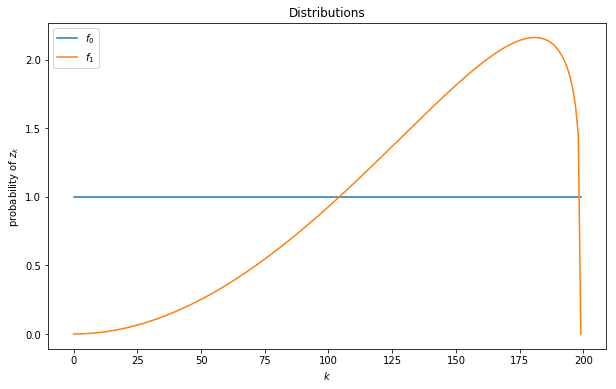

In [6]:
wf = WaldFriedman()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wf.f0(wf.π_grid), label="$f_0$")
ax.plot(wf.f1(wf.π_grid), label="$f_1$")
ax.set(ylabel="probability of $z_k$", xlabel="$k$", title="Distributions")
ax.legend()

plt.show()

### Value Function

To solve the model, we will call our `solve_model` function

In [7]:
h_star = solve_model(wf)  # solve the model

Error at iteration 25 is 9.281752977763347e-05.

Converged in 25 iterations.


We will also set up a function to compute the cutoffs $ \alpha $ and $ \beta $
and plot these on our value function plot

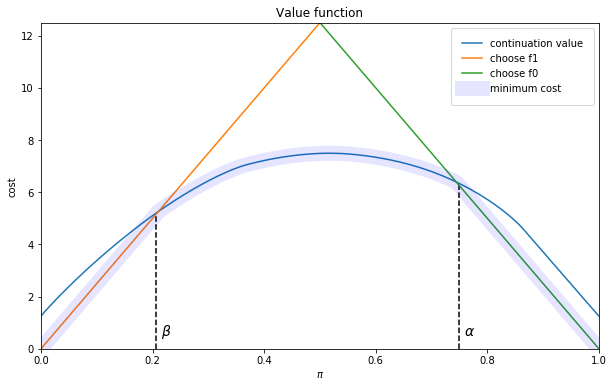

In [8]:
def find_cutoff_rule(wf, h):
    """
    This function takes a continuation value function and returns the corresponding
    cutoffs of where you transition between continue and choosing a
    specific model
    """
    π_grid = wf.π_grid
    L0, L1 = wf.L0, wf.L1

    # Evaluate cost at all points on grid for choosing a model
    payoff_f0 = (1 - π_grid) * L0
    payoff_f1 = π_grid * L1

    # The cutoff points can be found by differencing these costs with
    # the Bellman equation (J is always less than or equal to p_c_i)
    β = π_grid[np.searchsorted(payoff_f1 - h, 1e-10) - 1]
    α = π_grid[np.searchsorted(h - payoff_f0, -1e-10)]

    return (β, α)

β, α = find_cutoff_rule(wf, h_star)
cost_L0 = (1 - wf.π_grid) * wf.L0
cost_L1 = wf.π_grid * wf.L1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wf.π_grid, h_star, label='continuation value')
ax.plot(wf.π_grid, cost_L1, label='choose f1')
ax.plot(wf.π_grid, cost_L0, label='choose f0')
ax.plot(wf.π_grid, np.amin(np.column_stack([h_star, cost_L0, cost_L1]), axis=1),
        lw=15, alpha=0.1, color='b', label='minimum cost')

ax.annotate(r"$\beta$", xy=(β + 0.01, 0.5), fontsize=14)
ax.annotate(r"$\alpha$", xy=(α + 0.01, 0.5), fontsize=14)

plt.vlines(β, 0, β * wf.L0, linestyle="--")
plt.vlines(α, 0, (1 - α) * wf.L1, linestyle="--")

ax.set(xlim=(0, 1), ylim=(0, 0.5 * max(wf.L0, wf.L1)), ylabel="cost",
       xlabel="$\pi$", title="Value function")

plt.legend(borderpad=1.1)
plt.show()

The value function equals $ \pi L_1 $ for $ \pi \leq \beta $, and $ (1-\pi )L_0 $ for $ \pi
\geq \alpha $

The slopes of the two linear pieces of the value function are determined by $ L_1 $
and $ - L_0 $

The value function is smooth in the interior region, where the posterior
probability assigned to $ f_0 $ is in the indecisive region $ \pi \in (\beta, \alpha) $

The decision maker continues to sample until the probability that he attaches to
model $ f_0 $ falls below $ \beta $ or above $ \alpha $

### Simulations

The next figure shows the outcomes of 500 simulations of the decision process

On the left is a histogram of the stopping times, which equal the number of draws of $ z_k $ required to make a decision

The average number of draws is around 6.6

On the right is the fraction of correct decisions at the stopping time

In this case the decision maker is correct 80% of the time

Error at iteration 25 is 9.281752977763347e-05.

Converged in 25 iterations.


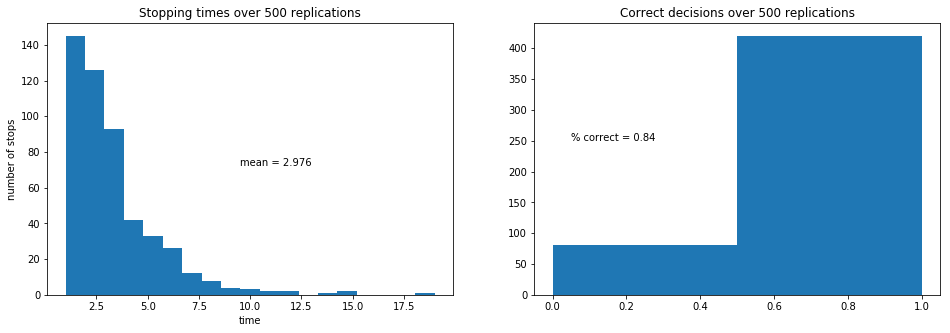

In [9]:
def simulate(wf, true_dist, h_star, π_0=0.5):
    """
    This function takes an initial condition and simulates until it
    stops (when a decision is made).
    """

    f0, f1 = wf.f0, wf.f1
    f0_rvs, f1_rvs = wf.f0_rvs, wf.f1_rvs
    π_grid = wf.π_grid

    def κ(z, π):
        """
        Updates π using Bayes' rule and the current observation z.
        """
        π_f0, π_f1 = π * f0(z), (1 - π) * f1(z)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

    if true_dist == "f0":
        f, f_rvs = wf.f0, wf.f0_rvs
    elif true_dist == "f1":
        f, f_rvs = wf.f1, wf.f1_rvs

    # Find cutoffs
    β, α = find_cutoff_rule(wf, h_star)

    # Initialize a couple useful variables
    decision_made = False
    π = π_0
    t = 0

    while decision_made is False:
        # Maybe should specify which distribution is correct one so that
        # the draws come from the "right" distribution
        z = f_rvs()
        t = t + 1
        π = κ(z, π)
        if π < β:
            decision_made = True
            decision = 1
        elif π > α:
            decision_made = True
            decision = 0

    if true_dist == "f0":
        if decision == 0:
            correct = True
        else:
            correct = False

    elif true_dist == "f1":
        if decision == 1:
            correct = True
        else:
            correct = False

    return correct, π, t

def stopping_dist(wf, h_star, ndraws=250, true_dist="f0"):
    """
    Simulates repeatedly to get distributions of time needed to make a
    decision and how often they are correct.
    """

    tdist = np.empty(ndraws, int)
    cdist = np.empty(ndraws, bool)

    for i in range(ndraws):
        correct, π, t = simulate(wf, true_dist, h_star)
        tdist[i] = t
        cdist[i] = correct

    return cdist, tdist

def simulation_plot(wf):
    h_star = solve_model(wf)
    ndraws = 500
    cdist, tdist = stopping_dist(wf, h_star, ndraws)

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    ax[0].hist(tdist, bins=np.max(tdist))
    ax[0].set_title(f"Stopping times over {ndraws} replications")
    ax[0].set(xlabel="time", ylabel="number of stops")
    ax[0].annotate(f"mean = {np.mean(tdist)}", xy=(max(tdist) / 2,
                   max(np.histogram(tdist, bins=max(tdist))[0]) / 2))

    ax[1].hist(cdist.astype(int), bins=2)
    ax[1].set_title(f"Correct decisions over {ndraws} replications")
    ax[1].annotate(f"% correct = {np.mean(cdist)}",
                   xy=(0.05, ndraws / 2))

    plt.show()

simulation_plot(wf)

### Comparative statics

Now let’s consider the following exercise

We double the cost of drawing an additional observation

Before you look, think about what will happen:

- Will the decision maker be correct more or less often?  
- Will he make decisions sooner or later?  


Converged in 14 iterations.


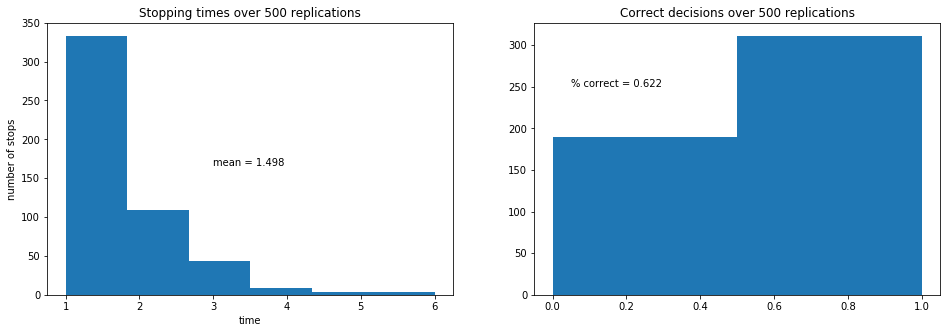

In [10]:
wf = WaldFriedman(c=2.5)
simulation_plot(wf)

Increased cost per draw has induced the decision maker to take less draws before deciding

Because he decides with less, the percentage of time he is correct drops

This leads to him having a higher expected loss when he puts equal weight on both models

### A notebook implementation

To facilitate comparative statics, we provide
a [Jupyter notebook](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/Wald_Friedman.ipynb) that
generates the same plots, but with sliders

With these sliders you can adjust parameters and immediately observe

- effects on the smoothness of the value function in the indecisive middle range
  as we increase the number of grid points in the piecewise linear  approximation  
- effects of different settings for the cost parameters $ L_0, L_1, c $, the
  parameters of two beta distributions $ f_0 $ and $ f_1 $, and the number
  of points and linear functions $ m $ to use in the piece-wise continuous approximation to the value function  
- various simulations from $ f_0 $ and associated distributions of waiting times to making a decision  
- associated histograms of correct and incorrect decisions  

## Comparison with Neyman-Pearson formulation

For several reasons, it is useful to describe the theory underlying the test
that Navy Captain G. S. Schuyler had been told to use and that led him
to approach Milton Friedman and Allan Wallis to convey his conjecture
that superior practical procedures existed

Evidently, the Navy had told
Captail Schuyler to use what it knew to be a state-of-the-art
Neyman-Pearson test

We’ll rely on Abraham Wald’s [[Wal47]](https://lectures.quantecon.org/py/zreferences.html#wald47) elegant summary of Neyman-Pearson theory

For our purposes, watch for there features of the setup:

- the assumption of a *fixed* sample size $ n $  
- the application of laws of large numbers, conditioned on alternative
  probability models, to interpret the probabilities $ \alpha $ and
  $ \beta $ defined in the Neyman-Pearson theory  


Recall that in the sequential analytic formulation above, that

- The sample size $ n $ is not fixed but rather an object to be
  chosen; technically $ n $ is a random variable  
- The parameters $ \beta $ and $ \alpha $ characterize cut-off
  rules used to determine $ n $ as a random variable  
- Laws of large numbers make no appearances in the sequential
  construction  


In chapter 1 of **Sequential Analysis** [[Wal47]](https://lectures.quantecon.org/py/zreferences.html#wald47) Abraham Wald summarizes the
Neyman-Pearson approach to hypothesis testing

Wald frames the problem as making a decision about a probability
distribution that is partially known

(You have to assume that *something* is already known in order to state a well
posed problem – usually, *something* means *a lot*)

By limiting  what is unknown, Wald uses the following simple structure
to illustrate the main ideas:

- a decision maker wants to decide which of two distributions
  $ f_0 $, $ f_1 $ govern an i.i.d. random variable $ z $  
- The null hypothesis $ H_0 $ is the statement that $ f_0 $
  governs the data  
- The alternative hypothesis $ H_1 $ is the statement that
  $ f_1 $ governs the data  
- The problem is to devise and analyze a test of hypothesis
  $ H_0 $ against the alternative hypothesis $ H_1 $ on the
  basis of a sample of a fixed number $ n $ independent
  observations $ z_1, z_2, \ldots, z_n $ of the random variable
  $ z $  


To quote Abraham Wald,

> A test procedure leading to the acceptance or rejection of the
hypothesis in question is simply a rule specifying, for each possible
sample of size $ n $, whether the hypothesis should be accepted
or rejected on the basis of the sample. This may also be expressed as
follows: A test procedure is simply a subdivision of the totality of
all possible samples of size $ n $ into two mutually exclusive
parts, say part 1 and part 2, together with the application of the
rule that the hypothesis be accepted if the observed sample is
contained in part 2. Part 1 is also called the critical region. Since
part 2 is the totality of all samples of size 2 which are not
included in part 1, part 2 is uniquely determined by part 1. Thus,
choosing a test procedure is equivalent to determining a critical
region.


Let’s listen to Wald longer:

> As a basis for choosing among critical regions the following
considerations have been advanced by Neyman and Pearson: In accepting
or rejecting $ H_0 $ we may commit errors of two kinds. We commit
an error of the first kind if we reject $ H_0 $ when it is true;
we commit an error of the second kind if we accept $ H_0 $ when
$ H_1 $ is true. After a particular critical region $ W $ has
been chosen, the probability of committing an error of the first
kind, as well as the probability of committing an error of the second
kind is uniquely determined. The probability of committing an error
of the first kind is equal to the probability, determined by the
assumption that $ H_0 $ is true, that the observed sample will be
included in the critical region $ W $. The probability of
committing an error of the second kind is equal to the probability,
determined on the assumption that $ H_1 $ is true, that the
probability will fall outside the critical region $ W $. For any
given critical region $ W $ we shall denote the probability of an
error of the first kind by $ \alpha $ and the probability of an
error of the second kind by $ \beta $.


Let’s listen carefully to how Wald applies a law of large numbers to
interpret $ \alpha $ and $ \beta $:

> The probabilities $ \alpha $ and $ \beta $ have the
following important practical interpretation: Suppose that we draw a
large number of samples of size $ n $. Let $ M $ be the
number of such samples drawn. Suppose that for each of these
$ M $ samples we reject $ H_0 $ if the sample is included in
$ W $ and accept $ H_0 $ if the sample lies outside
$ W $. In this way we make $ M $ statements of rejection or
acceptance. Some of these statements will in general be wrong. If
$ H_0 $ is true and if $ M $ is large, the probability is
nearly $ 1 $ (i.e., it is practically certain) that the
proportion of wrong statements (i.e., the number of wrong statements
divided by $ M $) will be approximately $ \alpha $. If
$ H_1 $ is true, the probability is nearly $ 1 $ that the
proportion of wrong statements will be approximately $ \beta $.
Thus, we can say that in the long run [ here Wald applies a law of
large numbers by driving $ M \rightarrow \infty $ (our comment,
not Wald’s) ] the proportion of wrong statements will be
$ \alpha $ if $ H_0 $is true and $ \beta $ if
$ H_1 $ is true.


The quantity $ \alpha $ is called the *size* of the critical region,
and the quantity $ 1-\beta $ is called the *power* of the critical
region

Wald notes that

> one critical region $ W $ is more desirable than another if it
has smaller values of $ \alpha $ and $ \beta $. Although
either $ \alpha $ or $ \beta $ can be made arbitrarily small
by a proper choice of the critical region $ W $, it is possible
to make both $ \alpha $ and $ \beta $ arbitrarily small for a
fixed value of $ n $, i.e., a fixed sample size.


Wald summarizes Neyman and Pearson’s setup as follows:

> Neyman and Pearson show that a region consisting of all samples
$ (z_1, z_2, \ldots, z_n) $ which satisfy the inequality

> $$
\frac{ f_1(z_1) \cdots f_1(z_n)}{f_0(z_1) \cdots f_1(z_n)} \geq k
$$


is a most powerful critical region for testing the hypothesis
$ H_0 $ against the alternative hypothesis $ H_1 $. The term
$ k $ on the right side is a constant chosen so that the region
will have the required size $ \alpha $.


Wald goes on to discuss Neyman and Pearson’s concept of *uniformly most
powerful* test

Here is how Wald introduces the notion of a sequential test

> A rule is given for making one of the following three decisions at any stage of
the experiment (at the m th trial for each integral value of m ): (1) to
accept the hypothesis H , (2) to reject the hypothesis H , (3) to
continue the experiment by making an additional observation. Thus, such
a test procedure is carried out sequentially. On the basis of the first
observation one of the aforementioned decisions is made. If the first or
second decision is made, the process is terminated. If the third
decision is made, a second trial is performed. Again, on the basis of
the first two observations one of the three decisions is made. If the
third decision is made, a third trial is performed, and so on. The
process is continued until either the first or the second decisions is
made. The number n of observations required by such a test procedure is
a random variable, since the value of n depends on the outcome of the
observations.

**Footnotes**

<p><a id=f1 href=#f1-link><strong>[1]</strong></a> Because the decision maker believes that $ z_{k+1} $ is
drawn from a mixture of two i.i.d. distributions, he does *not*
believe that the sequence $ [z_{k+1}, z_{k+2}, \ldots] $ is i.i.d.
Instead, he believes that it is *exchangeable*. See [[Kre88]](https://lectures.quantecon.org/py/zreferences.html#kreps88)
chapter 11, for a discussion of exchangeability.